# TDT17 Mini Project
### Road Crack Detection

The goal of this notebook is to help the road authorities in Trønderlag, Norway by detecting cracks in the road
on provided images. The goal is to create a model that can detect cracks in the road, making it easier for the
authorities to find and repair them. We will use the mean average precision (mAP) as a metric to evaluate the
performance of our model.

#### Importing libraries

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os
import lxml.etree as ET
import random

#### Setting up data paths

In [3]:
train_path = "./Norway/train/"
test_path = "./Norway/test/"
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
train_annotations_path = os.path.join(train_path, "annotations/xmls")

#### Fetching data from file
This will read the XML in the annotations folder and create a dictionary with the data valuable for the model. The data is transformed into a dictionary with the following format:
```python
{'image': {
    'path': './Norway/train/images/Norway_000005.jpg',
    'width': 3650, 
    'height': 2044}, 
'boxes': [
    {'type': 1, 'coords': (1140.27, 1164.62, 1280.35, 1199.79)}, 
    {'type': 1, 'coords': (155.59, 1601.83, 777.02, 2034.32)}, 
    {'type': 4, 'coords': (1190.21, 1354.48, 1290.52, 1406.12)}, 
    {'type': 4, 'coords': (1286.54, 1427.97, 1376.92, 1455.78)}, 
    {'type': 4, 'coords': (1472.27, 1202.5, 1550.7, 1232.32)}, 
    {'type': 4, 'coords': (1768.56, 1154.2, 1806.72, 1166.62)}, 
    {'type': 4, 'coords': (1756.32, 1466.71, 1810.94, 1497.49)}, 
    {'type': 1, 'coords': (1780.15, 1116.96, 1807.55, 1143.44)}, 
    {'type': 1, 'coords': (1649.16, 1530.54, 1748.22, 1862.11)}, 
    {'type': 4, 'coords': (1215.69, 1498.17, 1330.67, 1544.51)},
    {'type': 1, 'coords': (1345.11, 1122.55, 1538.99, 1192.21)},
    {'type': 1, 'coords': (11.42, 1823.22, 154.04, 1917.61)}, 
    {'type': 1, 'coords': (1583.06, 1139.79, 1637.62, 1170.14)}]
}
```

In [4]:
def elem2dict(node, attributes=True):
    """
    Convert an lxml.etree node tree into a dict.
    """
    result = {}
    if attributes:
        for item in node.attrib.items():
            key, result[key] = item

    for element in node.iterchildren():
        # Remove namespace prefix
        key = element.tag.split('}')[1] if '}' in element.tag else element.tag

        # Process element as tree element if the inner XML contains non-whitespace content
        if element.text and element.text.strip():
            value = element.text
        else:
            value = elem2dict(element)
        if key in result:
            if type(result[key]) is list:
                result[key].append(value)
            else:
                result[key] = [result[key], value]
        else:
            result[key] = value
    return result


# Converting from xml to dictionary
train_xml = [ET.parse(os.path.join(train_annotations_path, x)).getroot()
             for x in os.listdir(train_annotations_path)]
train_dicts = [elem2dict(x) for x in train_xml]

# Converting from dictionary to valid data format


def dict2data(dict):
    holetypes = {"D00": 1, "D10": 2, "D20": 3, "D40": 4}
    image = {"path": os.path.join(train_images_path, dict["filename"]), "width": int(
        dict["size"]["width"]), "height": int(dict["size"]["height"])}
    boxes = []
    if "object" in dict:
        if not type(dict["object"]) is list:
            dict["object"] = [dict["object"]]
        for object in dict["object"]:
            box = {}
            box["type"] = holetypes[object["name"]]
            box["coords"] = (float(object["bndbox"]["xmin"]),
                              float(object["bndbox"]["ymin"]),
                              float(object["bndbox"]["xmax"]),
                              float(object["bndbox"]["ymax"]))
            boxes.append(box)
    else:
        boxes = None
    return {"image": image, "boxes": boxes}


train_data_dict = [dict2data(x) for x in train_dicts]

#### Visualizing some data to check if it is correct

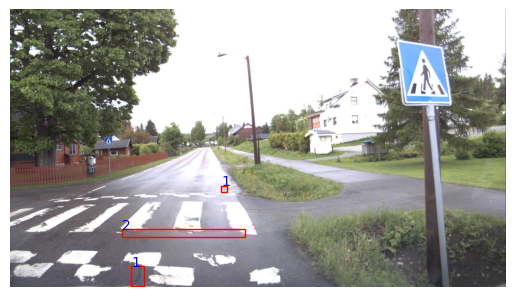

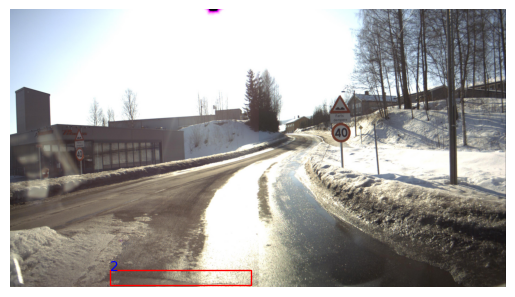

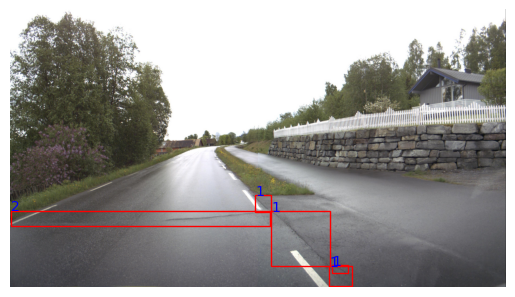

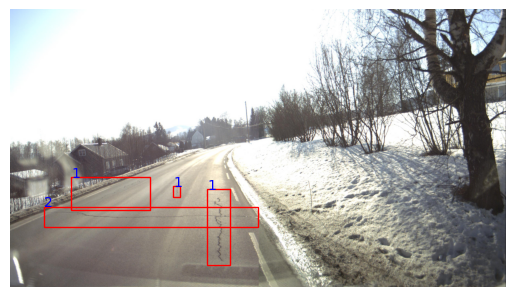

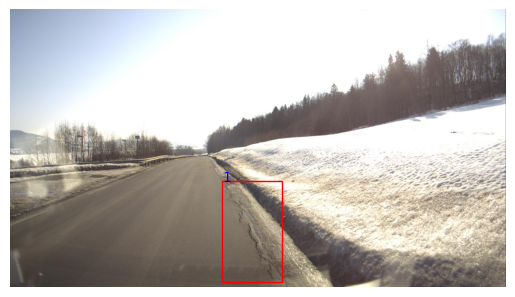

In [5]:
samples = []
while len(samples) < 5:
    data = random.choice(train_data_dict)
    if data["boxes"] is not None:
        samples.append(data)

for data in samples:
    image = Image.open(data["image"]["path"])
    boxes = data["boxes"]
    # draw bounding boxes on image and plot beside each other
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        xmin, ymin, xmax, ymax = box["coords"]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                             ymax - ymin, fill=False, color="red")
        ax.add_patch(rect)
        plt.text(xmin, ymin, box["type"], color="blue")
        plt.axis("off")
    plt.show()

    

#### Creating a dataset class